In [17]:
from pathlib import Path
import csv
import statistics
from typing import List, Dict

import matplotlib.pyplot as plt

# Configure paths
DATA_DIR = '../../downloaded_files/run-2025-10-22-074700/req-timeout568'

def read_csv_folder(folder: Path) -> List[Dict]:
    rows = []
    for p in sorted(folder.glob("out.csv")):
        with p.open("r", newline="") as f:
            reader = csv.DictReader(f)
            for row in reader:
                row["ok"] = row["ok"] in ("1", "True", "true")
                for k in ("e2e_ms", "server_latency_ms", "timeout_ms"):
                    if row.get(k):
                        try:
                            row[k] = float(row[k])
                        except Exception:
                            row[k] = None
                rows.append(row)
    return rows

def summarize(results: List[Dict]) -> Dict[str, float]:
    n = len(results)
    ok = sum(1 for r in results if r.get("ok"))
    e2e_vals = [r["e2e_ms"] for r in results if isinstance(r.get("e2e_ms"), (int, float))]
    mean_e2e = statistics.mean(e2e_vals) if e2e_vals else float("nan")
    p95 = (sorted(e2e_vals)[max(0, int(0.95 * len(e2e_vals)) - 1)] if e2e_vals else float("nan"))
    return {"n": n, "ok": ok, "success_rate": (ok / n) if n else float("nan"), "mean_e2e_ms": mean_e2e, "p95_e2e_ms": p95}

# Collect per-run summaries
run_dirs = sorted([d for d in Path(DATA_DIR).iterdir() if d.is_dir()])
summaries = []
for idx, d in enumerate(run_dirs):
    rows = read_csv_folder(d)
    s = summarize(rows)
    s["run_index"] = idx
    s["path"] = str(d)
    summaries.append(s)


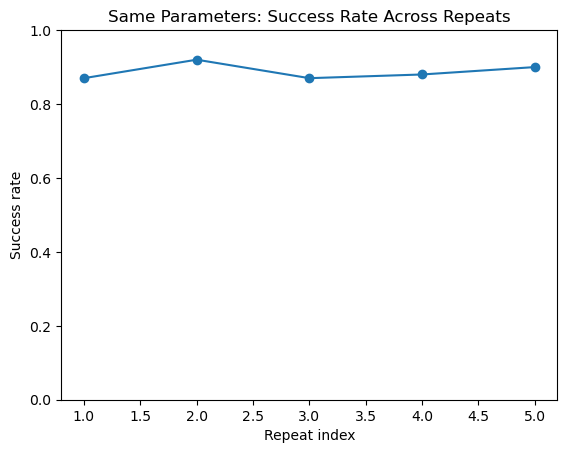

In [18]:
# Plot success rate across repeats
plt.figure()
plt.plot([s["run_index"] for s in summaries], [s["success_rate"] for s in summaries], marker="o")
plt.xlabel("Repeat index")
plt.ylabel("Success rate")
plt.title("Same Parameters: Success Rate Across Repeats")
plt.ylim(0, 1)
plt.show()

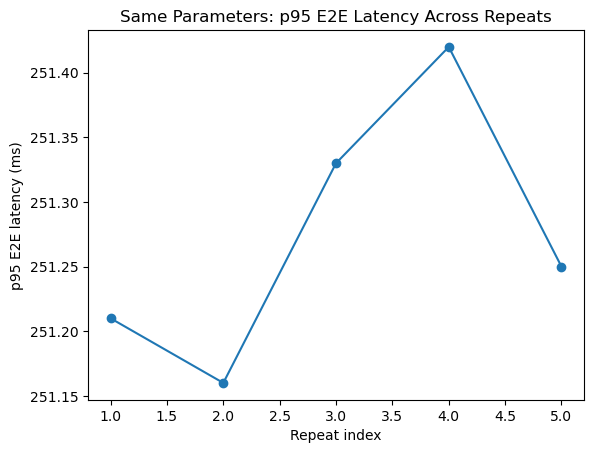

In [19]:
# Plot p95 latency across repeats
plt.figure()
plt.plot([s["run_index"] for s in summaries], [s["p95_e2e_ms"] for s in summaries], marker="o")
plt.xlabel("Repeat index")
plt.ylabel("p95 E2E latency (ms)")
plt.title("Same Parameters: p95 E2E Latency Across Repeats")
plt.show()